In [86]:
import json
import logging
from typing import List, Tuple

import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

from syndirella.SMARTSHandler import SMARTSHandler
from syndirella.route.Reaction import Reaction

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# Set the logging level for the PIL library to WARNING to suppress DEBUG logs
pil_logger = logging.getLogger('PIL')
pil_logger.setLevel(logging.WARNING)
# Suppress RDKit errors
RDLogger.DisableLog('rdApp.error')

# Purpose of this notebook: How to configure the fairydust functionality in Syndirella.

One of Syndirella's most important functionalities is fairydust 🧚 which specifies the chemists preferred reactant or reaction types, these specifications are in the following files:

#### `syndirella/constants/ADDITIONAL_RXN_OPTIONS.json`:

This file specifies reactions that should be replaced by another reaction to make a new route for the pipeline. Similar
to ``REACTANT_FILTER_CONSTANTS.json`` as it used to structure inputs for ``rdkit.Chem.ReplaceSubstructs()``. But instead
of adding the edited reactant to the library of reactants of one reaction, it is creating a completely new route.

The ``.json`` structure follows this format:

- ``name``: The reaction name that triggers for an additional route to be created with this reaction replaced  (e.g., "Amide_schotten-baumann"). Must match the reaction name in the ``RXN_SMIRKS_CONSTANTS.json``.

- ``replace_with``: The new reaction to replace the original reaction in a new route. This is the reaction you're swapping in (e.g., "Amidation").

- ``reactant_smarts_to_replace``: A SMARTS string of the atoms in the reactant you are directly editing for use in the new reaction.

- ``reactant_id_to_replace``: Specifies which reactant (by index, starting from 1) is being replaced in the original reaction SMIRKS.

- ``reactant_smarts_to_replace_with``: A SMARTS string specifying the reactant pattern that will replace the atoms found in ``reactant_smarts_to_replace``.

- ``replacement_connecting_atom_id``: The index of the atom in the ``reactant_smarts_to_replace_with`` that connects to the rest of the reactant. The index is 0-based, meaning it refers to the atom index in SMARTS minus 1.

Example entry:

```json

    {
        "name": "Amide_schotten-baumann",
        "replace_with": "Amidation",
        "reactant_smarts_to_replace": "[#6X3;!$(C-N):1](=[OX1:2])-[#17,#9,#35:3]",
        "reactant_id_to_replace": 2,
        "reactant_smarts_to_replace_with": "[#6X3;!$(C-N):1](=[OX1:2])-[#8;H1:3]",
        "replacement_connecting_atom_id": 0
    }
```

#### `syndirella/constants/REACTANT_FILTER_CONSTANTS.json`:

This file defines options to transform reactants in specific reactions. Such as transforming a boronic acid to a boronate ester. The transformed
reactant is used as an additional reactant in the library of reactants. It is used to structure inputs for ``rdkit.Chem.ReplaceSubstructs()``.

The ``.json`` structure follows this format:

- **Key (e.g., "Sp2-sp2_Suzuki_coupling")**: This indicates the specific reaction type being targeted.

- **SMARTS Pattern (e.g., "[#5](-[#8])(-[#8])")**: The SMARTS pattern to be modified for a reactant. Each reaction type can have multiple SMARTS patterns that describe specific substructures to look for in the reactants. These patterns are used to identify the appropriate atoms for modification.

- **Values**:
    - ``name``: Describes the action to take (e.g., `"add_boronate_ester"`). This is the modification to be applied when the SMARTS pattern is found.
    - ``to_add``: Specifies the SMARTS string of the atoms to be added to the structure. For instance, a boronate ester group ("[#6]-[#6]1(-[#6])-[#8]-[#5]-[#8]-[#6]-1(-[#6])-[#6]") might be added.
    - ``connecting_atom_id``: Specifies the index (0-based) of the atom in ``to_add`` that will connect to the existing structure. This number corresponds to the atom's position in the SMARTS string.

Example entry:

```json

    {
      "Sp2-sp2_Suzuki_coupling": {
        "[#5](-[#8])(-[#8])": {
          "name": "add_boronate_ester",
          "to_add": "[#6]-[#6]1(-[#6])-[#8]-[#5]-[#8]-[#6]-1(-[#6])-[#6]",
          "connecting_atom_id": 4
        },
        "[#9,#17,#53]": {
          "name": "add_bromine",
          "to_add": "[#35]",
          "connecting_atom_id": 0
        }
      }
    }
```

## Configuring the `ADDITIONAL_RXN_OPTIONS.json` file
#### Goal: Add an additional reaction option for the `Formation_of_urea_from_two_amines` reaction with the reaction, `Formation_of_urea_by_displacement_of_imidazole_by_amine`.

To build a new entry we can start with:
```json
{
    "name": "Formation_of_urea_from_two_amines",
    "replace_with": "Formation_of_urea_by_displacement_of_imidazole_by_amine",
    "reactant_smarts_to_replace": "_",
    "reactant_id_to_replace": int(),
    "reactant_smarts_to_replace_with": "_",
    "replacement_connecting_atom_id": int()
  }
```

We need:
- [ ] SMIRKS pattern for new reaction and add that to our `RXN_SMIRKS_CONSTANTS.json` file.
- [ ] SMARTS pattern of the exact atoms in reactant in `Formation_of_urea_from_two_amines` to replace ('reactant_smarts_to_replace').
- [ ] Id of the reactant in Formation_of_urea_from_two_amines to replace ('reactant_id_to_replace').
- [ ] SMARTS pattern of new reactant to replace the atoms in reactant ('reactant_smarts_to_replace_with').
- [ ] Index of the atom in the new reactant that connects to the rest of the reactant ('replacement_connecting_atom_id').

### Step 1: Write the new reaction.

Assuming you already have beginning SMIRKS pattern to work with, let's load that.

2025-02-15 16:39:24,538 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2025-02-15 16:39:24,539 - PIL.PngImagePlugin - DEBUG - STREAM b'bKGD' 41 6
2025-02-15 16:39:24,539 - PIL.PngImagePlugin - DEBUG - b'bKGD' 41 6 (unknown)
2025-02-15 16:39:24,540 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 59 8192
2025-02-15 16:39:24,542 - PIL.PngImagePlugin - DEBUG - STREAM b'zTXt' 15786 456
2025-02-15 16:39:24,542 - PIL.PngImagePlugin - DEBUG - STREAM b'zTXt' 16254 78


Formation of urea by displacement of imidazole by amine


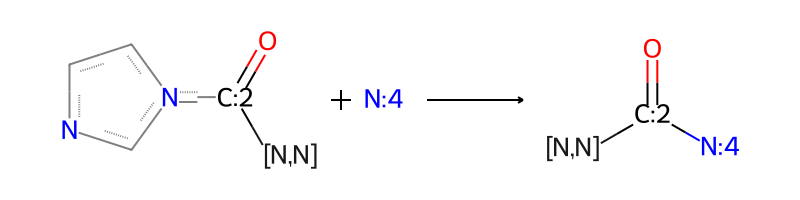

In [61]:
smirks: str = '[n,N:1]-[C:2](=[O])n1ccnc1.[N:4]>>[n,N:1]-[C:2](=[O])-[N:4]'
reaction = ReactionFromSmarts(smirks)
print('Formation of urea by displacement of imidazole by amine')
Draw.ReactionToImage(reaction)

> **Important:** Make sure the smirks is specific as possible. Think about exact reactivity here with the atom environment of the reacting atoms.
>
> Things to think about:
> - Are there any parts of the reactant you don't want to elaborate?
> - Are there any functional groups in the environment of the reactant atoms that will impact reactivity?

Let's improve this SMIRKS. I use [https://smarts.plus/](https://smarts.plus/) to do this. You can find information on how to write [SMIRKS](https://www.daylight.com/dayhtml/doc/theory/theory.smirks.html) and [SMARTS](https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html).


2025-02-15 16:39:24,570 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2025-02-15 16:39:24,570 - PIL.PngImagePlugin - DEBUG - STREAM b'bKGD' 41 6
2025-02-15 16:39:24,571 - PIL.PngImagePlugin - DEBUG - b'bKGD' 41 6 (unknown)
2025-02-15 16:39:24,571 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 59 8192
2025-02-15 16:39:24,573 - PIL.PngImagePlugin - DEBUG - STREAM b'zTXt' 14738 642
2025-02-15 16:39:24,573 - PIL.PngImagePlugin - DEBUG - STREAM b'zTXt' 15392 128


Formation of urea by displacement of imidazole by amine


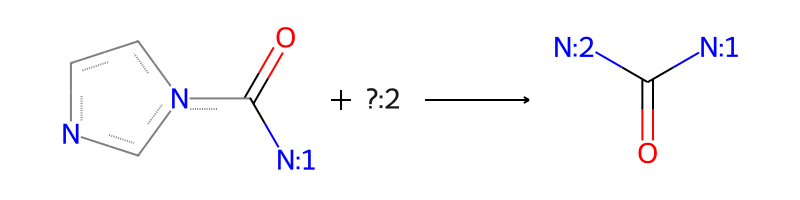

In [62]:
smirks: str = '[#7:1]-[C](=[#8X1])[nX3]1[c&H1X3][c&H1X3][nX2][c&H1X3]1.[$([N+0&H1,N+0&H2]);!$(NC=*);!$(NS);!$(N=*);!$(N-O);!$(N-o):2]>>[#7:1]-[C](=[#8X1])-[#7:2]'
reaction = ReactionFromSmarts(smirks)
print('Formation of urea by displacement of imidazole by amine')
Draw.ReactionToImage(reaction)
# TODO: Display image from SMARTS PLUS

Changes made moving from the first SMIRKS to the second:
|Reactant/Product| Original | Improved | Reason |
|--------|----------|----------|--------|
|R.1| [n,N:1]  | [#7:1]   | More general nitrogen atom type with `#7`.|
|R.1| [C:2]    | [C]      | Removed atom number since not important. |
|R.1| (=[O]) | (=[#8X1]) | General oxygen atom type and specifying no further connections after double bond. |
|R.1| n1ccnc1 | [nX3]1[c&H1X3][c&H1X3][nX2][c&H1X3]1 | Using the `X` to exactly specify the number of connections per atom so elaborations aren't added.|
|R.2| [N:4] | `[$([N+0&H1,N+0&H2]);!$(NC=*);!$(NS);!$(N=*);!$(N-O);!$(N-o):2]` | Specifying the nitrogen must be a primary or secondary amine and not be a part of an amide, sulfonamide, or bonded to an oxygen. |
|P| [n,N:1] | [#7:1] | More general nitrogen atom type with `#7`. |
|P| [C:2] | [C] | Removed atom number since not important. |
|P| (=[O]) | (=[#8X1]) | General oxygen atom type and specifying no further connections after double bond. |
|P| [N:4] | [#7:2] | More general nitrogen atom type with `#7` and correct atom number. |


### Step 2: Test new reaction.

We need to test our new SMIRKS pattern to ensure it works as expected. Let's load some example data for the new reaction.

In [63]:
df = pd.read_csv('fairydust_example_data/urea_formation_from_imidazole_tests.csv')

Reactant 1


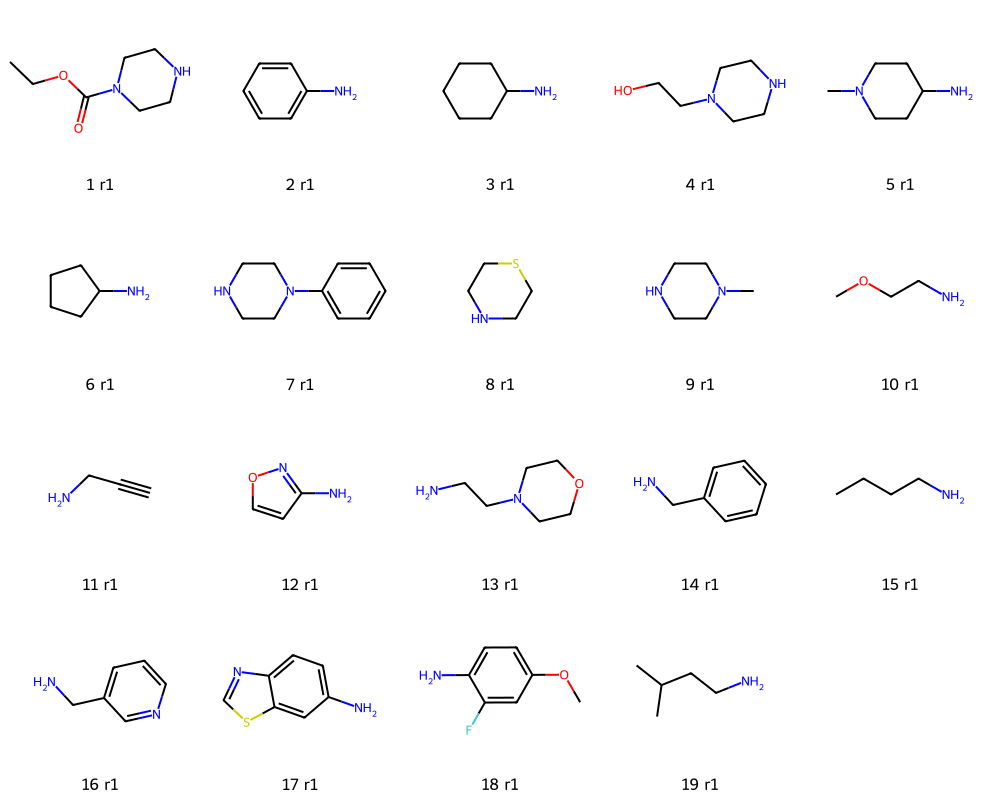

In [64]:
# Lets look at the reactants
r1 = [Chem.MolFromSmiles(reactant) for reactant in df['reactant-1'] if pd.notna(reactant)]
r2 = [Chem.MolFromSmiles(reactant) for reactant in df['reactant-2'] if pd.notna(reactant)]
print('Reactant 1')
Draw.MolsToGridImage(r1, legends=[f"{i + 1} r1" for i in range(len(r1))], molsPerRow=5)

Reactant 2


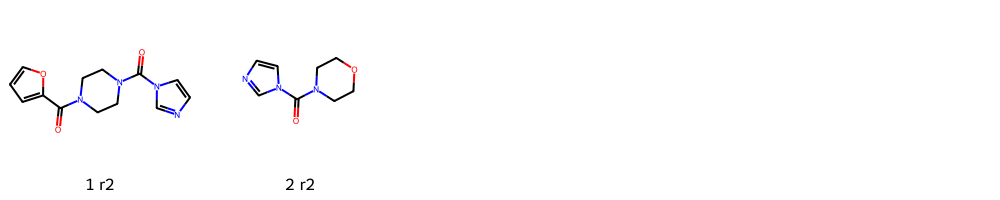

In [65]:
print('Reactant 2')
Draw.MolsToGridImage(r2, legends=[f"{i + 1} r2" for i in range(len(r2))], molsPerRow=5)

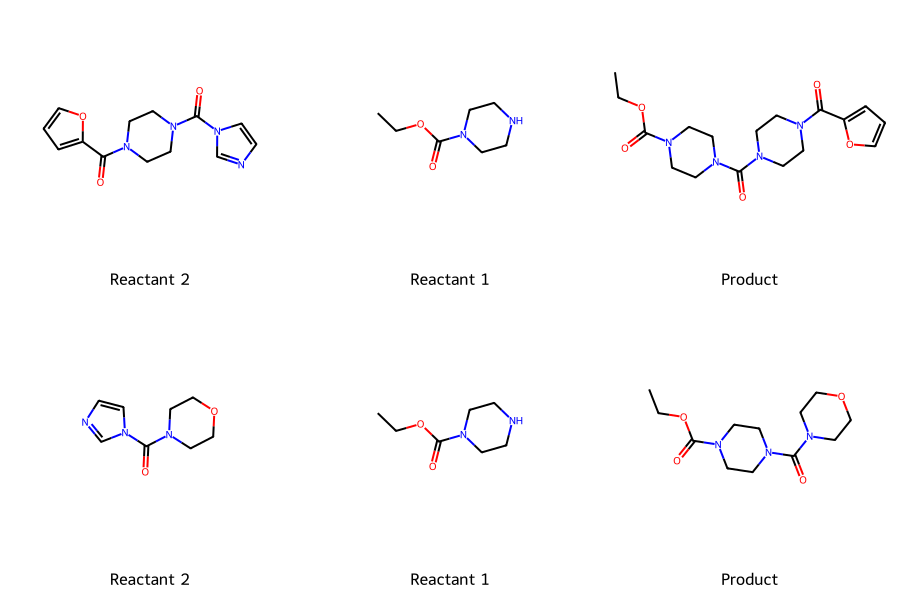

In [66]:
# Lets apply the reaction to all reactant combinations, and display the products
products = []
errored = []
legends = []
errored_legend = []
for reactant1 in r1:
    for reactant2 in r2:
        try:
            reaction.RunReactants((reactant2, reactant1))[0][0]
        except IndexError:  # no products for this reactant combination
            errored.append(reactant2)
            errored.append(reactant1)
            errored_legend.extend([f"Reactant 2", f"Reactant 1"])
            continue
        products.append(reactant2)
        products.append(reactant1)
        products.append(reaction.RunReactants((reactant2, reactant1))[0][0])
        legends.extend([f"Reactant 2", f"Reactant 1", f"Product"])
Draw.MolsToGridImage(products[:6], legends=legends, molsPerRow=3, subImgSize=(300, 300))

In [67]:
# Display errored reactant combinations
print('Errored reactant combinations', len(errored))

Errored reactant combinations 0


Everything looks good! There were no errored reactions and/or products that didn't look right. Let's move on to the next step.

### Step 3: Define how to replace reactants in the old reaction.

Now we need to determine and define which reactant in the `Formation_of_urea_from_two_amines` reaction we'd like to change and what atoms to change. I'll load the examples below.

In [68]:
df = pd.read_csv('fairydust_example_data/formation_of_urea_examples.csv')
df

,smiles,1_r1_smiles,1_r2_smiles,1_reaction
0,CCc1nc(NC(=O)N2CCN(C(=O)c3ccco3)CC2)no1,O=C(c1ccco1)N1CCNCC1,CCc1nc(N)no1,Formation_of_urea_from_two_amines
1,CC1(NC(=O)Nc2ccccc2CS(N)(=O)=O)CCC1,Nc1ccccc1CS(N)(=O)=O,CC1(N)CCC1,Formation_of_urea_from_two_amines
2,CCCC(=O)NC1CCN(C(=O)NC2CC(CC#N)C2)CC1,N#CCC1CC(N)C1,CCCC(=O)NC1CCNCC1,Formation_of_urea_from_two_amines


Formation of urea from two amines


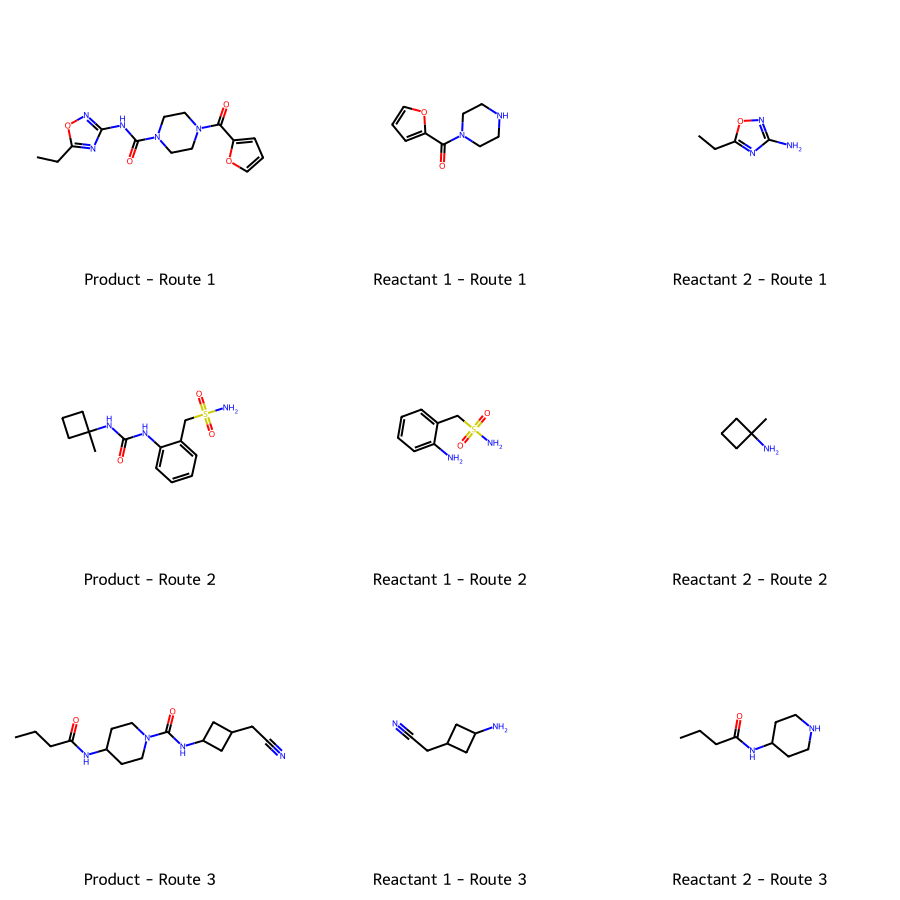

In [69]:
# Iterate through each row and create a list of Mol objects for each reactant
mols = []
legends = []
for index, row in df.iterrows():
    smiles = [row['smiles'], row['1_r1_smiles'], row['1_r2_smiles']]
    mols.append([Chem.MolFromSmiles(reactant) for reactant in smiles])
    legends.append(
        [f'Product - Route {index + 1}', f'Reactant 1 - Route {index + 1}', f'Reactant 2 - Route {index + 1}'])

# Flatten the list of Mol objects and legends
flat_mols = [mol for sublist in mols for mol in sublist]
flat_legends = [legend for sublist in legends for legend in sublist]

# Display the Mol objects in a grid image
print('Formation of urea from two amines')
Draw.MolsToGridImage(flat_mols, legends=flat_legends, molsPerRow=3, subImgSize=(300, 300))

From just manual viewing, either of the amine reactant groups can be replaced with a imidazole ketone group. For now, just specify the first reactant to be replaced with `reactant_id_to_replace` = 1. The SMARTS pattern for the amine group to replace is `[N+0&H1,N+0&H2]` (and not an amide, sulfonamide, or bonded to an oxygen specified by the functional groups not allowed to be matched to with !). The SMARTS pattern for the imidazole ketone group to replace with is just using the exact one from the SMIRKS. The atom in the imidazole ketone group that connects to the rest of the reactant is the nitrogen atom with label 1 (`[#7:1]`) and since the index is 0 based, the `replacement_connecting_atom_id = 0`.

In [1]:
#TODO: Need to work out how to show 'reactant_id_to_replace' and 'replacement_connecting_atom_id'

New reactant atoms to add:


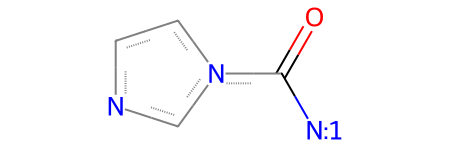

In [70]:
new_config = [{
    'name': 'Formation_of_urea_from_two_amines',
    'replace_with': 'Formation_of_urea_by_displacement_of_imidazole_by_amine',
    'reactant_smarts_to_replace': "[$([N+0&H1,N+0&H2]);!$(NC=*);!$(NS);!$(N=*);!$(N-O);!$(N-o)]",
    'reactant_id_to_replace': 2,
    'reactant_smarts_to_replace_with': "[#7:1]-[C](=[#8X1])[nX3]1[c&H1X3][c&H1X3][nX2][c&H1X3]1",
    'replacement_connecting_atom_id': 0  # nitrogen atom in imidazole ketone group with label 1
}]

# can also view at [https://smarts.plus/smartsview](https://smarts.plus/smartsview)
print("New reactant atoms to add:")
Chem.MolFromSmarts(new_config[0]['reactant_smarts_to_replace_with'])

### Step 4: Test the replacement.

Let's test the replacement on the examples we have by creating a Reaction object and running the same functions Syndirella uses on the `Formation of urea from two amines` examples.

In [71]:
# Add new reaction to dummy rxn smirks file for testing
with open('../../syndirella/constants/RXN_SMIRKS_CONSTANTS.json', 'r') as file:
    rxn_smirks = json.load(file)
rxn_smirks['Formation_of_urea_by_displacement_of_imidazole_by_amine'] = smirks
# save
rxn_smirks_path = 'fairydust_example_data/RXN_SMIRKS_CONSTANTS_TEST.json'
with open(rxn_smirks_path, 'w') as file:
    json.dump(rxn_smirks, file, indent=4)

In [72]:
product: Chem.Mol = Chem.MolFromSmiles(df['smiles'][0])
reactants: List[Chem.Mol] = [Chem.MolFromSmiles(df['1_r1_smiles'][0]), Chem.MolFromSmiles(df['1_r2_smiles'][0])]
reaction_name: str = 'Formation_of_urea_from_two_amines'
smarts_handler: SMARTSHandler = SMARTSHandler(rxn_smirks_path=rxn_smirks_path)
route_uuid: str = '12345'
logger = logging.getLogger(f"{__name__}")
rxn = Reaction(product=product, reactants=reactants, reaction_name=reaction_name, smarts_handler=smarts_handler,
               route_uuid=route_uuid)
rxn.logger = logger
rxn.alt_reactions = new_config
new_reaction: List[Tuple[str, Tuple[
    str, str]]] = rxn.get_additional_reactions()  # returns a list of tuples with the reaction name and reactants
new_reaction

2025-02-15 16:39:24,880 - syndirella.SMARTSHandler - WARNING - Both reactants (O=C(c1ccco1)N1CCNCC1 CCc1nc(N)no1) have atoms found in SMARTS of 1st reactant for Formation_of_urea_from_two_amines. This might cause selectivity issues downstream, but continuing.
2025-02-15 16:39:24,880 - syndirella.SMARTSHandler - WARNING - Both reactants (O=C(c1ccco1)N1CCNCC1 CCc1nc(N)no1) have atoms found in SMARTS of 2nd reactant for Formation_of_urea_from_two_amines. This might cause selectivity issues downstream, but continuing.
2025-02-15 16:39:24,881 - __main__ - INFO - Additional reaction Formation_of_urea_by_displacement_of_imidazole_by_amine found for Formation_of_urea_from_two_amines.
2025-02-15 16:39:24,882 - __main__ - INFO - to_replace_with_smarts: [#7:1]-[C](=[#8X1])[nX3]1[c&H1X3][c&H1X3][nX2][c&H1X3]1
2025-02-15 16:39:24,882 - __main__ - INFO - Found 1 new reactants.
2025-02-15 16:39:24,882 - __main__ - INFO - Checking new reactant CCc1nc([NH:1]C(=O)n2ccnc2)no1 for reaction Formation_of_ur

[('Formation_of_urea_by_displacement_of_imidazole_by_amine',
  ('CCc1nc([NH:1]C(=O)n2ccnc2)no1', 'O=C(c1ccco1)N1CCNCC1'))]

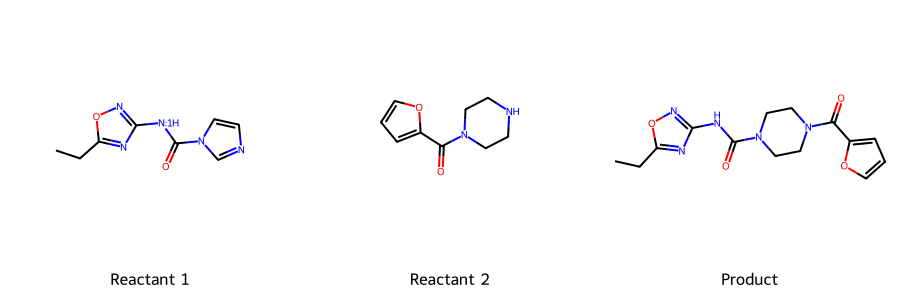

In [73]:
# Display and test the new reaction
r1 = Chem.MolFromSmiles(new_reaction[0][1][0])
r2 = Chem.MolFromSmiles(new_reaction[0][1][1])
reaction: Chem.rdChemReactions = ReactionFromSmarts(smirks)
new_reactant_combo: Tuple[Chem.Mol] = (r1, r2)
products: Tuple[Chem.Mol] = reaction.RunReactants(new_reactant_combo)
pred_prod = products[0][0]
Draw.MolsToGridImage([r1, r2, pred_prod], legends=['Reactant 1', 'Reactant 2', 'Product'], molsPerRow=3,
                     subImgSize=(300, 300))

In [74]:
# does the product match the original product? Compare with inchi key
expected_inchi = Chem.MolToInchiKey(product)
pred_inchi = Chem.MolToInchiKey(pred_prod)
print(f'Expected Inchi: {expected_inchi}')
print(f'Predicted Inchi: {pred_inchi}')
print(f'Inchi Match: {expected_inchi == pred_inchi}')

Expected Inchi: XNVDJLXZBJHKFV-UHFFFAOYSA-N
Predicted Inchi: XNVDJLXZBJHKFV-UHFFFAOYSA-N
Inchi Match: True


In [75]:
# test on all other examples
for i in range(1, len(df)):
    product: Chem.Mol = Chem.MolFromSmiles(df['smiles'][i])
    reactants: List[Chem.Mol] = [Chem.MolFromSmiles(df['1_r1_smiles'][i]), Chem.MolFromSmiles(df['1_r2_smiles'][i])]
    rxn = Reaction(product=product, reactants=reactants, reaction_name=reaction_name, smarts_handler=smarts_handler,
                   route_uuid=route_uuid)
    rxn.logger = logger
    rxn.alt_reactions = new_config
    new_reaction: List[Tuple[str, Tuple[
        str, str]]] = rxn.get_additional_reactions()  # returns a list of tuples with the reaction name and reactants
    r1 = Chem.MolFromSmiles(new_reaction[0][1][0])
    r2 = Chem.MolFromSmiles(new_reaction[0][1][1])
    reaction: Chem.rdChemReactions = ReactionFromSmarts(smirks)
    new_reactant_combo: Tuple[Chem.Mol] = (r1, r2)
    products: Tuple[Chem.Mol] = reaction.RunReactants(new_reactant_combo)
    pred_prod = products[0][0]
    expected_inchi = Chem.MolToInchiKey(product)
    pred_inchi = Chem.MolToInchiKey(pred_prod)
    print(f'Expected Inchi: {expected_inchi}')
    print(f'Predicted Inchi: {pred_inchi}')
    print(f'Inchi Match: {expected_inchi == pred_inchi}')

2025-02-15 16:39:24,956 - syndirella.SMARTSHandler - WARNING - Both reactants (Nc1ccccc1CS(N)(=O)=O CC1(N)CCC1) have atoms found in SMARTS of 1st reactant for Formation_of_urea_from_two_amines. This might cause selectivity issues downstream, but continuing.
2025-02-15 16:39:24,957 - syndirella.SMARTSHandler - WARNING - Both reactants (Nc1ccccc1CS(N)(=O)=O CC1(N)CCC1) have atoms found in SMARTS of 2nd reactant for Formation_of_urea_from_two_amines. This might cause selectivity issues downstream, but continuing.
2025-02-15 16:39:24,957 - __main__ - INFO - Additional reaction Formation_of_urea_by_displacement_of_imidazole_by_amine found for Formation_of_urea_from_two_amines.
2025-02-15 16:39:24,958 - __main__ - INFO - to_replace_with_smarts: [#7:1]-[C](=[#8X1])[nX3]1[c&H1X3][c&H1X3][nX2][c&H1X3]1
2025-02-15 16:39:24,958 - __main__ - INFO - Found 1 new reactants.
2025-02-15 16:39:24,958 - __main__ - INFO - Checking new reactant CC1([NH:1]C(=O)n2ccnc2)CCC1 for reaction Formation_of_urea_fro

Expected Inchi: QCDPODCBNROZRQ-UHFFFAOYSA-N

2025-02-15 16:39:24,962 - syndirella.SMARTSHandler - WARNING - Both reactants (N#CCC1CC(N)C1 CCCC(=O)NC1CCNCC1) have atoms found in SMARTS of 1st reactant for Formation_of_urea_from_two_amines. This might cause selectivity issues downstream, but continuing.



Predicted Inchi: QCDPODCBNROZRQ-UHFFFAOYSA-N
Inchi Match: True


2025-02-15 16:39:24,962 - syndirella.SMARTSHandler - WARNING - Both reactants (N#CCC1CC(N)C1 CCCC(=O)NC1CCNCC1) have atoms found in SMARTS of 2nd reactant for Formation_of_urea_from_two_amines. This might cause selectivity issues downstream, but continuing.
2025-02-15 16:39:24,962 - __main__ - INFO - Additional reaction Formation_of_urea_by_displacement_of_imidazole_by_amine found for Formation_of_urea_from_two_amines.
2025-02-15 16:39:24,963 - __main__ - INFO - to_replace_with_smarts: [#7:1]-[C](=[#8X1])[nX3]1[c&H1X3][c&H1X3][nX2][c&H1X3]1
2025-02-15 16:39:24,963 - __main__ - INFO - Found 1 new reactants.
2025-02-15 16:39:24,963 - __main__ - INFO - Checking new reactant CCCC(=O)NC1CC[N:1](C(=O)n2ccnc2)CC1 for reaction Formation_of_urea_from_two_amines...
2025-02-15 16:39:24,964 - __main__ - INFO - New reactant for reaction Formation_of_urea_from_two_amines found.
2025-02-15 16:39:24,964 - __main__ - INFO - Additional reaction Formation_of_urea_by_displacement_of_imidazole_by_amine for

Expected Inchi: ADKGLDCQLGUTAN-UHFFFAOYSA-N
Predicted Inchi: ADKGLDCQLGUTAN-UHFFFAOYSA-N
Inchi Match: True


Nice! It's worked as expected. The new reaction has been created and the reactants have been replaced as expected. Now we can add this to the `ADDITIONAL_RXN_OPTIONS.json` file and save a new `RXN_SMIRKS_CONSTANTS.json` file.

In [76]:
# write new ADDITIONAL_RXN_OPTIONS.json
path = '../../syndirella/constants/ADDITIONAL_RXN_OPTIONS.json'
with open(path, 'r') as file:
    additional_rxn_options = json.load(file)
# check if entry already exists
entry_exists = False
for entry in additional_rxn_options:
    # check if all values are the same
    if all([entry[key] == new_config[0][key] for key in new_config[0].keys()]):
        entry_exists = True
        print(f"Entry with name {new_config[0]['name']} and all same values already exists.")
        break

# add new entry if it doesn't exist
if not entry_exists:
    additional_rxn_options.extend(new_config)
    # save
    with open(path, 'w') as file:
        json.dump(additional_rxn_options, file, indent=4)

Entry with name Formation_of_urea_from_two_amines and all same values already exists.


In [77]:
# write new RXN_SMIRKS_CONSTANTS.json
path = '../../syndirella/constants/RXN_SMIRKS_CONSTANTS.json'
with open(path, 'r') as file:
    rxn_smirks = json.load(file)
rxn_smirks['Formation_of_urea_by_displacement_of_imidazole_by_amine'] = smirks
# save
with open(path, 'w') as file:
    json.dump(rxn_smirks, file, indent=4)

## Configuring the `REACTANT_FILTER_CONSTANTS.json` file

## TODO

In [88]:
# test out reaction
from rdkit.Chem import AllChem, rdFMCS
import numpy as np


def align_mols_and_get_closest_atoms(mol1, mol2, pattern=None):
    """
    Align two molecules and find closest atom pairs.

    Args:
        mol1: First RDKit molecule
        mol2: Second RDKit molecule
        pattern: Optional SMARTS pattern for alignment (if None, uses MCS)

    Returns:
        tuple: (aligned mol2, list of (idx1, idx2) pairs of closest atoms)
    """
    # Generate 3D conformers if they don't exist
    if not mol1.GetNumConformers():
        AllChem.EmbedMolecule(mol1, randomSeed=42)
        AllChem.MMFFOptimizeMolecule(mol1)
    if not mol2.GetNumConformers():
        AllChem.EmbedMolecule(mol2, randomSeed=42)
        AllChem.MMFFOptimizeMolecule(mol2)

    # Create copy of mol2 for alignment
    mol2_aligned = Chem.Mol(mol2)

    if pattern:
        # Use provided SMARTS pattern
        qmol = Chem.MolFromSmarts(pattern)
        matches1 = mol1.GetSubstructMatch(qmol)
        matches2 = mol2_aligned.GetSubstructMatch(qmol)
        if not (matches1 and matches2):
            raise ValueError("Pattern not found in both molecules")
    else:
        # Find Maximum Common Substructure
        mcs = rdFMCS.FindMCS([mol1, mol2_aligned])
        qmol = Chem.MolFromSmarts(mcs.smartsString)
        matches1 = mol1.GetSubstructMatch(qmol)
        matches2 = mol2_aligned.GetSubstructMatch(qmol)

    # Align mol2 to mol1 based on matching atoms
    AllChem.AlignMol(mol2_aligned, mol1, atomMap=list(zip(matches2, matches1)))

    # Get coordinates for all atoms
    conf1 = mol1.GetConformer()
    conf2 = mol2_aligned.GetConformer()

    # Find closest atoms
    closest_pairs = []
    for i in range(mol1.GetNumAtoms()):
        pos1 = conf1.GetAtomPosition(i)
        pos1_array = np.array([pos1.x, pos1.y, pos1.z])

        # Find closest atom in mol2
        min_dist = float('inf')
        closest_idx = -1

        for j in range(mol2_aligned.GetNumAtoms()):
            pos2 = conf2.GetAtomPosition(j)
            pos2_array = np.array([pos2.x, pos2.y, pos2.z])

            dist = np.linalg.norm(pos1_array - pos2_array)
            if dist < min_dist:
                min_dist = dist
                closest_idx = j

        closest_pairs.append((i, closest_idx))

    return mol2_aligned, closest_pairs


smiles = "C1C=C(NC(C(C(NC2C=CC(OC3C4C=C(NC=4N=CC=3)C(NCCN3CCOCC3)=O)=CC=2)=O)2CC2)=O)C=CC=1F"
fragment = "C1C=CC=C2N=CC=NC=12"
ring = '[#6]1:[#6]:[#6]:[#7]:[#6]:[#6]:1'
mol = Chem.MolFromSmiles(smiles)
frag_mol = Chem.MolFromSmiles(fragment)
ring_mol = Chem.MolFromSmarts(ring)
ring_mol.UpdatePropertyCache(strict=False)
ring_mol = Chem.AddHs(ring_mol)
Chem.Kekulize(ring_mol)

mol2_aligned, closest_pairs = align_mols_and_get_closest_atoms(frag_mol, ring_mol)

[17:11:10] Molecule does not have explicit Hs. Consider calling AddHs()
[17:11:10] Molecule does not have explicit Hs. Consider calling AddHs()


In [79]:
# find the atoms that were attached to larger molecule in substructure
def find_connection_atoms(mol, ring):
    ring_mol = Chem.MolFromSmarts(ring)
    matches = mol.GetSubstructMatch(ring_mol)
    # Convert to set for efficient lookup
    substructure_atoms = set(matches)
    print(matches)
    # Find atoms that connect to atoms outside substructure
    connection_atoms = set()
    for atom_idx in substructure_atoms:
        atom = mol.GetAtomWithIdx(atom_idx)
        # Look at all neighbors of this atom
        for neighbor in atom.GetNeighbors():
            if neighbor.GetIdx() not in substructure_atoms:
                connection_atoms.add(atom_idx)
                break
    return list(connection_atoms)


def create_labeled_mol(mol):
    # Generate 2D coordinates if needed
    if not mol.GetNumConformers():
        AllChem.Compute2DCoords(mol)

    # Create molecule with atom indices as labels
    for atom in mol.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))

    return Draw.MolToImage(mol, size=(400, 400))


find_connection_atoms(mol, ring)

(13, 14, 18, 19, 20, 21)


[18, 13, 14]

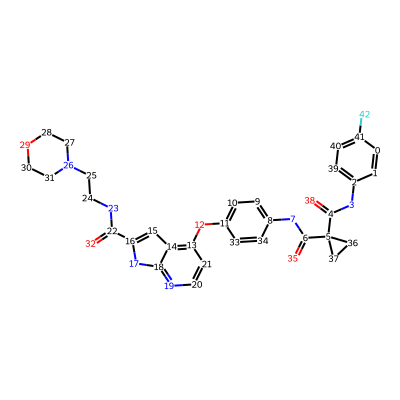

In [90]:
# show mol with atoms labeled
create_labeled_mol(mol)

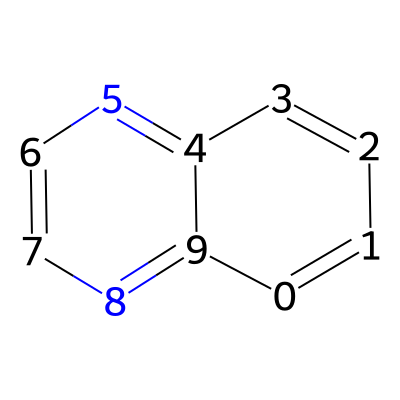

In [92]:
create_labeled_mol(frag_mol)

In [93]:
Chem.MolToSmarts(frag_mol)

'[#6]1:[#6]:[#6]:[#6]:[#6]2:[#7]:[#6]:[#6]:[#7]:[#6]:1:2'

In [94]:
Chem.MolToSmiles(Chem.MolFromSmarts('[#6]1:[#6]2:[#6]:[#6]:[#7H]:[#6]:2:[#7]:[#6]:[#6]:1'))

'C1:C:N:C2:N:C:C:C:2:C:1'

In [82]:
# Create reaction from SMARTS
rxn = Chem.AllChem.ReactionFromSmarts(
    '[#6:1]1:[#6]:[#6]:[#7]:[#6]:[#6]:1>>[#6:1]1(:[#6](:[#6](:[#6](:[#6]2:[#7]:[#6](:[#6](:[#7]:[#6]:1:2)-[H])-[H])-[H])-[H])-[H])-[H]')

# Apply to molecule
mol = Chem.MolFromSmiles(smiles)
products = rxn.RunReactants((mol,))

# Get the product (first product of first reaction)
if products:
    for product in products:
        product = product[0]
        # Sanitize the product
        Chem.SanitizeMol(product)
        # Convert to SMILES to see result
        product_smiles = Chem.MolToSmiles(product)
        print(f"Product SMILES: {product_smiles}")

KekulizeException: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9

2025-02-15 16:39:50,590 - __main__ - INFO - Got 1 successful replacements!


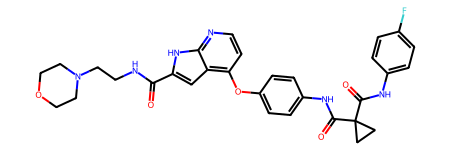

In [84]:
def replace_substructure(
        mol: Chem.Mol, substructure: Chem.Mol, replacement: Chem.Mol
) -> List[str]:
    """
    Given a mol, substructure to replace, and a replacement, this returns a list of SMILES of molecules with incorporated
    replacement.
    :param mol: Mol to incorporate replacement.
    :param substructure: Mol of substructure to replace.
    :param replacement: Mol of replacement.
    :return: list of Chem.Mol objects with replacement.
    """
    replaced_mols: Tuple[Chem.Mol] = Chem.ReplaceSubstructs(
        mol=mol,
        query=substructure,
        replacement=replacement,
        replacementConnectionPoint=0,
        replaceAll=False,
    )
    replaced_mols: List[Chem.Mol | None] = [
        Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in replaced_mols
    ]  # make sure that the replaced_mols can be fully transformed into SMILES and back into mol objects

    logger.info(f"Got {len(replaced_mols)} successful replacements!")
    for i, mol in enumerate(replaced_mols, 1):
        logger.debug(f"  {i}. {Chem.MolToSmiles(mol)}")
    return replaced_mols


replaced_mols = replace_substructure(mol, ring_mol, frag_mol)
replaced_mols[0]

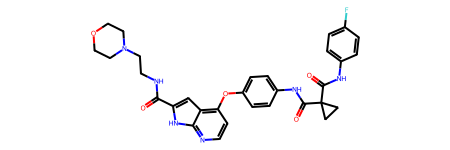

In [85]:
mol